In [ ]:
#TODO:implement rotation checking for images????
#TODO: implement orientation checking for images
#TODO: test using performance vs epoch graphs etc

In [1]:
import numpy as np
import imageio
import cv2
import matplotlib.pyplot
import imutils
#import scipy
#from scipy import special
from PIL import Image

In [2]:
class NeuralNetwork:
    
    #initialise neural network
    def __init__(self, givenINodes, givenHNodes, givenONodes, givenLearningRate):
        #setup number of nodes in each layer
        self.inputNodes = givenINodes
        self.hiddenNodes = givenHNodes
        self.outputNodes = givenONodes
        
        #setup weights with initial values
        self.weightsInputHidden = np.random.normal(0.0, pow(self.inputNodes, -0.5), (self.hiddenNodes, self.inputNodes))
        self.weightsHiddenOutput = np.random.normal(0.0, pow(self.hiddenNodes, -0.5), (self.outputNodes, self.hiddenNodes))
        
        #setup learning rate
        self.learningRate = givenLearningRate
        
        #setup activation function
        #self.activationFunc = lambda x: scipy.special.expit(x)
        self.activationFunc = lambda x: self.sigmoid(x)
            
        pass
            
    def sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        return A
    
    #train the neural network
    def train(self, givenInputs, givenTargets):
        #inputs and target lists turned into 2D arrays
        inputs = np.array(givenInputs, ndmin=2).T
        targets = np.array(givenTargets, ndmin=2).T
        
        #signals into hidden layer calculated
        hiddenInputs = np.dot(self.weightsInputHidden, inputs)
        #signals coming from hidden layer calculated
        hiddenOutputs = self.activationFunc(hiddenInputs)
        
        #signals into output layer calculated
        finalInputs = np.dot(self.weightsHiddenOutput, hiddenOutputs)
        #signals from output layer calculated
        finalOutputs = self.activationFunc(finalInputs)
        
        #error backpropagation:
        #errors from output layer
        outputErrors = targets - finalOutputs
        #errors from hidden layer
        hiddenErrors = np.dot(self.weightsHiddenOutput.T, outputErrors)
        
        #weight links updated between all layers
        self.weightsHiddenOutput += self.learningRate * np.dot((outputErrors * finalOutputs * (1.0 - finalOutputs)), np.transpose(hiddenOutputs))
        self.weightsInputHidden += self.learningRate * np.dot((hiddenErrors * hiddenOutputs * (1.0 - hiddenOutputs)), np.transpose(inputs))
        
        pass
    
    #query the neural network
    def query(self, givenInputs):
        #inputs list converted into a 2D array
        inputs = np.array(givenInputs, ndmin=2).T
        
        #signals into hidden layer calculated
        hiddenInputs = np.dot(self.weightsInputHidden, inputs)
        #signals coming from hidden layer calculated
        hiddenOutputs = self.activationFunc(hiddenInputs)
        
        #signals into output layer calculated
        finalInputs = np.dot(self.weightsHiddenOutput, hiddenOutputs)
        #final signals from neural net calculated
        finalOutputs = self.activationFunc(finalInputs)
        
        return finalOutputs
    
        

In [3]:
#set number of nodes in each layer
inputNodes = 2025 #2025
hiddenNodes = 750
outputNodes = 500

#set learning rate
learningRate = 0.37

#an instance of the neural network created
n = NeuralNetwork(inputNodes, hiddenNodes, outputNodes, learningRate)

In [4]:
#open training data file in READ mode
#trainingDataFile = open("mnist_dataset/mnist_train.csv",'r')
trainingDataFile = open("img_pixels.csv",'r')
#save all the lines from the file into a list
trainingDataList = trainingDataFile.readlines()
#close the file
trainingDataFile.close()

trainingDataLabelsFile = open("img_labels.txt",'r')
#save all the lines from the file into a list
trainingDataLabelsList = trainingDataLabelsFile.readlines()
#close the file
trainingDataLabelsFile.close()

#DEBUG
print(trainingDataList)
print("--")
print(trainingDataLabelsList)

['0,1,2,0,1,254,255,1,0,3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,255,255,0,0,2,0,0,3,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,1,0,0,253,255,2,1,1,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,255,255,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,254,1,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,1,1,255,0,0,0,4,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,255,1,1,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,255,1,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,0,0,2,0,1,0,0,3,0,0,0,0,0,2,0,1,0,1,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,254,0,1,2,0,2,0,2,0,0,4,1,4,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,0,0,0,4,0,0,0,0,0,0,2,2,0,2,0,0,0,3,0,1,0,0,5,

In [5]:
#trainPrep
#number of times training data used for training
epochs = 10

for e in range(epochs):
    #for every record in the training data
    for record in trainingDataList:
        #split each record by the commas
        allVals = record.split(',')
        #scale and shift the inputs
        #inputs = (np.asfarray(allVals[1:]) / 255.0 * 0.99) + 0.01
        inputs = (np.asfarray(allVals) / 255.0 * 0.99) + 0.01
        
        #target output values created
        targets = np.zeros(outputNodes) + 0.01
        #targets[int(allVals[0])] = 0.99
        #targets[int(trainingDataLabelsList[record])] = 0.99
        currentIndex = trainingDataList.index(record)
        #print(currentIndex)
        targets[currentIndex] = 0.99
        n.train(inputs, targets)
        
        pass
    #print(len(allVals))
    #print(len(trainingDataLabelsList))
    #print(targets)
    #for c in range(0, len(trainingDataLabelsList)):
    #    targets[c] = 0.99
    #n.train(inputs, targets)
    pass

#print(allVals)
#print(inputs[166])
#print(targets)

In [18]:
im = Image.open('separated/test.jpg') 
sqrWidth = np.ceil(np.sqrt(im.size[0]*im.size[1])).astype(int) 
im_resize = im.resize((sqrWidth, sqrWidth)) 
im_resize.save('output.png')

Loading image...
Min: 0.01
Max: 1.0
[[0.00617164]
 [0.0095072 ]
 [0.00755822]
 [0.00721516]
 [0.00511345]
 [0.00620802]
 [0.01457188]
 [0.00847254]
 [0.00845978]
 [0.0080926 ]
 [0.00890719]
 [0.02974439]
 [0.00729144]
 [0.01014107]
 [0.00956129]
 [0.01743378]
 [0.00923309]
 [0.01221049]
 [0.01516012]
 [0.00854334]
 [0.00649187]
 [0.00862473]
 [0.01150829]
 [0.01750632]
 [0.00769991]
 [0.01202537]
 [0.0045496 ]
 [0.01475886]
 [0.01019334]
 [0.01312527]
 [0.00742287]
 [0.00860894]
 [0.01382886]
 [0.007964  ]
 [0.01265721]
 [0.01297779]
 [0.01208698]
 [0.00523706]
 [0.01305536]
 [0.00801922]
 [0.00784258]
 [0.00979969]
 [0.01379624]
 [0.01010807]
 [0.01129585]
 [0.00703641]
 [0.01022738]
 [0.00717439]
 [0.0082917 ]
 [0.00996312]
 [0.01107226]
 [0.00542446]
 [0.00960442]
 [0.0060598 ]
 [0.01128126]
 [0.01014866]
 [0.01348344]
 [0.01159585]
 [0.00935099]
 [0.00926943]
 [0.010755  ]
 [0.01226513]
 [0.00908675]
 [0.0058541 ]
 [0.00621794]
 [0.0078089 ]
 [0.01161499]
 [0.00928484]
 [0.0102559 

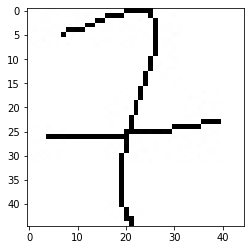

In [19]:
print ("Loading image...")
imageArray = imageio.imread('output.png', as_gray=True)

imageRotated = imutils.rotate(imageArray, 360)
#imageResized = imageRotated.reshape(28,28)
imageResized = cv2.resize(imageRotated, (45, 45), cv2.INTER_AREA)

imageData = 255.0 - imageResized.reshape(2025)
imageData = (imageData / 255.0 * 0.99) + 0.01

print ("Min:", np.min(imageData))
print ("Max:", np.max(imageData))

matplotlib.pyplot.imshow(imageData.reshape(45,45), cmap='Greys', interpolation='None')

outputs = n.query(imageData)

print (outputs)

#label = np.argmax(outputs)
labelIndex = np.argmax(outputs)
label = trainingDataLabelsList[labelIndex]
print ("Predicted value:", label)
